In [52]:
import pandas as pd
import numpy as np
import geopandas
import ast
import datetime
import plotly.graph_objects as go
import plotly.express as px

#! pip install geopandas

Modelo predictivo 


In [2]:
# lectura datos
datos=pd.read_csv("incidentes_viales.csv",sep=";",encoding='ansi',engine="python")
filtro=datos["CLASE_ACCIDENTE"].isna()
datos=datos[~filtro]
diccionario_temp={
'Caida Ocupante':"Caida ocupante",
       'Caída de Ocupante':"Caida ocupante",
    'Caída Ocupante':"Caida ocupante", 
       'Caida de Ocupante':"Caida ocupante"}
datos["CLASE_ACCIDENTE"]=datos["CLASE_ACCIDENTE"].replace(diccionario_temp)
##########################################################################################
# transformacion fechas y año.
# existen fechas con Sin Inf asumimos es que no hay una hora precisa del accidente.
datos["FECHA_ACCIDENTE_"]=pd.to_datetime(datos["FECHA_ACCIDENTE"].apply(lambda x: x.replace("Sin Inf","00:00:00") ))
datos["DIAS_REF"]= datos["FECHA_ACCIDENTE_"]-pd.to_datetime("2014-01-01 00:00:00" )
datos["DIAS_REF"]=datos["DIAS_REF"].apply(lambda x : x.days)
# datos["DIAS_REF"].astype(int)
datos["AÑO"]=datos["AÑO"].apply(lambda x: int(str(x).replace("\\r","")) )
##########################################################################################



0       2
1       3
2       4
3       5
4       6
       ..
2522    4
2523    5
2524    6
2525    0
2526    1
Name: 0, Length: 2527, dtype: int64

In [22]:
dia_max

2533

In [60]:
dia_max=datos["DIAS_REF"].max() # dia maximo
dia_min=datos["DIAS_REF"].min() # dia minimo
datos_temp=pd.DataFrame(pd.date_range(start=datos["FECHA_ACCIDENTE_"].min(),end=datos["FECHA_ACCIDENTE_"].max()))

datos["Y"]=1 # cantidad de accidentes
seq_dias=list(range(dia_min,dia_max+1 )) # secuencia de dias
tipo_accidente=np.repeat( datos["CLASE_ACCIDENTE"].unique(),len(seq_dias))  # tipo por la secuencia del tiempo
datos_modelo=pd.DataFrame({"DIAS_REF": seq_dias*datos["CLASE_ACCIDENTE"].nunique(), # datos modelo
                           "FECHA_ACCIDENTE":list(datos_temp[0])*datos["CLASE_ACCIDENTE"].nunique(),
                          "CLASE_ACCIDENTE":tipo_accidente,
                          "DIA_SEMANA":list(datos_temp[0].dt.weekday)*datos["CLASE_ACCIDENTE"].nunique() } )
datos_modelo=datos_modelo.merge(datos[["DIAS_REF","CLASE_ACCIDENTE","Y"]],how="left", 
                   left_on=["DIAS_REF","CLASE_ACCIDENTE"], 
                   right_on=["DIAS_REF","CLASE_ACCIDENTE"])
datos_modelo["Y"]=datos_modelo["Y"].fillna(0)
datos_modelo=datos_modelo.groupby(["DIAS_REF","CLASE_ACCIDENTE","FECHA_ACCIDENTE","DIA_SEMANA"]).sum().reset_index()
datos_modelo=datos_modelo.sort_values("DIAS_REF")

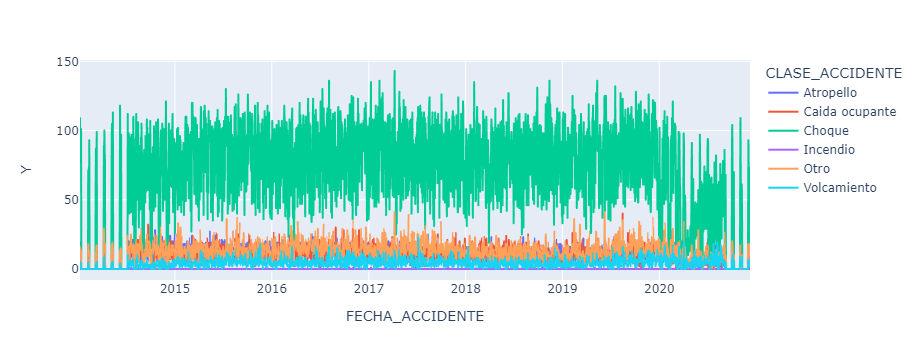

In [63]:
fig = px.line(datos_modelo, x="FECHA_ACCIDENTE", y="Y", color='CLASE_ACCIDENTE')
fig.show()

Agrupamiento 

In [17]:
# lectura barrios shape
shapefile = geopandas.read_file("Barrio_Vereda.shp")
# str to list
datos["LOCATION"]=datos["LOCATION"].apply(lambda x: ast.literal_eval(x))
# dataframe to geopandas
# sistema de referencia datos : ITRF94
gdf = geopandas.GeoDataFrame(
    datos, geometry=geopandas.points_from_xy(datos.LOCATION.apply(lambda x: x[0]),
                                             datos.LOCATION.apply(lambda x: x[1]),
                                            crs="ITRF94"))
# cambiar sistema de refencia 
# sistema de refencia de barrios es: EPSG:4326
gdf=gdf.to_crs("EPSG:4326")
# join barrios medellin y datos
datos_join=geopandas.sjoin(gdf,shapefile , how='left') 
datos_join=geopandas.sjoin(shapefile,gdf , how='left') 

In [18]:
datos_join.columns

Index(['OBJECTID', 'CODIGO', 'NOMBRE', 'SUBTIPO_BA', 'SHAPEAREA', 'SHAPELEN',
       'geometry', 'index_right', 'AÑO', 'CBML', 'CLASE_ACCIDENTE',
       'DIRECCION', 'DIRECCION ENCASILLADA', 'DISEÑO', 'EXPEDIENTE',
       'FECHA_ACCIDENTE', 'FECHA_ACCIDENTES', 'GRAVEDAD_ACCIDENTE', 'MES',
       'NRO_RADICADO', 'NUMCOMUNA', 'BARRIO', 'COMUNA', 'LOCATION', 'X', 'Y',
       'FECHA_ACCIDENTE_', 'DIAS_REF'],
      dtype='object')

In [11]:
datos_join.drop(labels=["OBJECTID","index_right"], axis=1)

Index(['OBJECTID', 'CODIGO', 'NOMBRE', 'SUBTIPO_BA', 'SHAPEAREA', 'SHAPELEN',
       'geometry', 'index_right', 'AÑO', 'CBML', 'CLASE_ACCIDENTE',
       'DIRECCION', 'DIRECCION ENCASILLADA', 'DISEÑO', 'EXPEDIENTE',
       'FECHA_ACCIDENTE', 'FECHA_ACCIDENTES', 'GRAVEDAD_ACCIDENTE', 'MES',
       'NRO_RADICADO', 'NUMCOMUNA', 'BARRIO', 'COMUNA', 'LOCATION', 'X', 'Y',
       'FECHA_ACCIDENTE_', 'DIAS_REF'],
      dtype='object')

In [20]:
datos_temp.columns[-7:]

Index(['OBJECTID', 'CODIGO', 'NOMBRE', 'SUBTIPO_BA', 'SHAPEAREA', 'SHAPELEN',
       'geometry_y'],
      dtype='object')

In [12]:
filtro=~datos.EXPEDIENTE.isin(datos_join.EXPEDIENTE)
datos_temp=datos.loc[filtro,:].merge(shapefile,left_on="BARRIO", right_on="NOMBRE" ).copy()

In [30]:
datos_join["DIAS_REF"]=datos_join["DIAS_REF"].apply(lambda x : x.days)

In [31]:
datos_join.columns

Index(['OBJECTID', 'CODIGO', 'NOMBRE', 'SUBTIPO_BA', 'SHAPEAREA', 'SHAPELEN',
       'geometry', 'index_right', 'AÑO', 'CBML', 'CLASE_ACCIDENTE',
       'DIRECCION', 'DIRECCION ENCASILLADA', 'DISEÑO', 'EXPEDIENTE',
       'FECHA_ACCIDENTE', 'FECHA_ACCIDENTES', 'GRAVEDAD_ACCIDENTE', 'MES',
       'NRO_RADICADO', 'NUMCOMUNA', 'BARRIO', 'COMUNA', 'LOCATION', 'X', 'Y',
       'FECHA_ACCIDENTE_', 'DIAS_REF'],
      dtype='object')

In [ ]:
datos_join["DIA"]=datos_join["FECHA_ACCIDENTE_"].apply(lambda x: x.day)
datos_join["DIA"]=datos_join["FECHA_ACCIDENTE_"].apply(lambda x: strftime( x,"%w") )
# datos_join["DIA"]=datos_join["FECHA_ACCIDENTE_"].apply(lambda x: x.date)

ValueError: NaTType does not support timetuple

In [56]:
datetime.datetime.strftime( datos_join["FECHA_ACCIDENTE_"].iloc[0],"%W")

'05'

In [53]:
datos_join["FECHA_ACCIDENTE_"].iloc[0]

Timestamp('2016-02-04 12:30:00')

In [34]:
datos_join.MES

0       4.0
0       6.0
0       1.0
0      12.0
0       4.0
       ... 
330     1.0
330    12.0
330    12.0
331     3.0
331     4.0
Name: MES, Length: 250498, dtype: float64

In [43]:
datos_prueba=datos_join.groupby([ "NOMBRE", "CLASE_ACCIDENTE" ,"DIA", "MES", "AÑO"]).count()["Y"].reset_index()

In [46]:
datos_prueba.Y.describe()

count    157675.000000
mean          1.588590
std           1.900324
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          49.000000
Name: Y, dtype: float64

In [6]:
shapefile[shapefile["NOMBRE"]=="Guayabal"]

,OBJECTID,CODIGO,NOMBRE,SUBTIPO_BA,SHAPEAREA,SHAPELEN,geometry
190,972,1510,Guayabal,1,747197.185348,4132.516706,"POLYGON ((-75.58111 6.19704, -75.58162 6.19666..."


In [3]:
datos.loc[,"BARRIO"].value_counts(dropna=False)

NaN                              18798
0                                 1036
Guayabal                           354
1510                                16
Caribe                               9
Los Balsos No.2                      3
Cabecera San Antonio de Prado        3
El Chagualo                          3
Asomadera No. 1                      2
Plaza de Ferias                      2
El Progreso                          1
Palermo                              1
Terminal de Transporte               1
Fuente Clara                         1
Parque Norte                         1
Sin Inf                              1
Volcana Guayabal                     1
Área de Expansión Pajarito           1
Santa Mónica                         1
La Alpujarra                         1
Name: BARRIO, dtype: int64

In [98]:
(datos["AÑO"].value_counts()-datos_join["AÑO"].value_counts())/datos["AÑO"].value_counts()

2016      0.077256
2017      0.077135
2015      0.076670
2018      0.072835
2019\r    0.050561
2014      0.074459
2020      0.066187
2019      0.107696
Name: AÑO, dtype: float64

2016      47103
2017      46205
2015      46172
2018      43358
2019\r    26760
2014      22415
2020      19717
2019      19035
Name: AÑO, dtype: int64

archivo .shape o argis mapa de medellín discriminado pro barrios.

En la columna FECHA_ACCIDENTE existen registros con "Sin Inf" que según parece es que no se tiene información de la hora del accidente.

In [4]:
filtro=datos["AÑO"]<=2018
train=datos[filtro].copy()
test=datos[~filtro].copy()

In [5]:
test

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,FECHA_ACCIDENTES,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y
27915,2019,0605,Choque,CL 94 CR 72 A,CL 094 072 A 000 00000,Interseccion,A000923458,08/01/2019 21:10:00,2019-01-09T02:10:00.000Z,Solo da\xF1os,1,1656117,06,La Esperanza,Doce de Octubre,"[-75.5762596222, 6.28969552163]",834138.74,1187511.75
27916,2019,0605,Choque,CL 94 CR 72 A,CL 094 072 A 000 00000,Tramo de via,A000923374,08/01/2019 21:30:00,2019-01-09T02:30:00.000Z,Solo da\xF1os,1,1656066,06,La Esperanza,Doce de Octubre,"[-75.5762596222, 6.28969552163]",834138.74,1187511.75
27917,2019,1603,Choque,CL 30 CR 77,CL 030 077 000 00000,Interseccion,A000923118,08/01/2019 23:40:00,2019-01-09T04:40:00.000Z,Con heridos,1,1655916,16,Bel\xE9n,Bel\xE9n,"[-75.5970734554, 6.23131316566]",831816.14,1181059.81
27918,2019,NaN,Choque,CL 8 CR 680,CL 008 680 000 00000,Tramo de via,A000923373,09/01/2019 02:45:00,2019-01-09T07:45:00.000Z,Solo da\xF1os,1,1656072,Sin Inf,NaN,NaN,"[-75.7037762763, 6.22141524356]",820000.00,1180000.00
27919,2019,0517,Caida Ocupante,CR 63 CL 67,CR 063 067 000 00000,Tramo de via,A000923126,09/01/2019 04:55:00,2019-01-09T09:55:00.000Z,Con heridos,1,1656008,05,Caribe,Castilla,"[-75.5742390745, 6.26534417189]",834354.70,1184817.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270760,2020,1004,Caida Ocupante,CR 62 CL 59,CR 062 059 000 00000,Tramo de via,A001164101,31/08/2020 18:50:00,2020-08-31T23:50:00.000Z,Con heridos,8,1722059,10,El Chagualo,La Candelaria,"[-75.5731343044, 6.26063534822]",834475.51,1184295.99
270761,2020,1115,Otro,CL 50 CR 74,CL 050 074 000 00000,Tramo de via,A001164214,31/08/2020 18:50:00,2020-08-31T23:50:00.000Z,Con heridos,8,1722080,11,Cuarta Brigada,Laureles Estadio,"[-75.5902062951, 6.26040455473]",832585.61,1184275.87
270762,2020,515,Choque,CL 80 CR 65,CL 080 065 000 00000,Tramo de via,A001164472,31/08/2020 19:05:00,2020-09-01T00:05:00.000Z,Solo daños,8,1722288,5,Cementerio Universal,Castilla,"[-75.5735398111, 6.27625838886]",834435.55,1186024.41
270763,2020,207,Atropello,CL 104 CR 45,CL 104 045 000 00000,Tramo de via,A001164109,31/08/2020 19:30:00,2020-09-01T00:30:00.000Z,Con heridos,8,1722062,2,Villa del Socorro,Santa Cruz,"[-75.5515085985, 6.29359892373]",836879.66,1187935.77
